In [ ]:
'''
Code and Formal Analysis accompanying the following publication in Clinical Therapeutics (insert date),
"Regional (in)Consistency and Comparability of Cannabis Laboratory Testing: 
A Statistical Exploration of Total Yeast and Mold" 
by Graham Antoszewski, Heather Carrasco, Jini Glaros, & Mackenzie Slade (insert doi)

Thoughts? Questions? Consternations? Please reach out to corresponding author: graham.antoszewski@gmail.com
MIT License 
Copyright (c) 2025 Graham Antoszewski
'''

import numpy as np
import scipy
import sklearn.metrics
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy.stats import lognorm, gengamma, gamma
import scipy
from scipy.special import kl_div

plt.rcParams.update({
    'font.size': 14,      # Set the global font size
    'font.family': 'serif',  # Set the global font family
    'font.serif': 'Times New Roman'  # Set a specific serif font
})

In [83]:
# read in state TYM data
df = pd.read_csv('5 States YM Combined_v2.csv',encoding='latin-1')

# stats=df['TestResult'].describe()
# stats

print(len(df[df.State=='MA']))

# extracting the TYM testing from CCC public data
# cccdf = pd.read_csv('Testing_Data_THC_THCA_Y&M-2021-2023.csv')
# cccdf['Test Performed Date'] = pd.to_datetime(cccdf['Test Performed Date'],format='mixed')
# ccc_filtered_df = cccdf[cccdf['Test Performed Date'].dt.year == 2023]
# ccc_bud_df = ccc_filtered_df[ccc_filtered_df['ProductCategoryType']=='Buds']
# ccc_ym_df= ccc_filtered_df[ccc_filtered_df['Test Type Name']== 'Total Yeast and Mold (CFU/g) Raw Plant Material']
# ccc_ym_df.to_csv('Testing_Data_Y&M_2023.csv')

ccc_ym_df = pd.read_csv('Testing_Data_Y&M_2023.csv')
print(len(ccc_ym_df))

ddf=df[df.State=='MA']
ccc_ym_df['TestingLab(ITL)'].unique(),ddf['Testing Facility Id'].unique()

45295
54473


(array(['LabE', 'LabB', 'LabO', 'LabA', 'LabZ', 'LabH', 'LabY', 'LabP',
        'LabG', 'LabX', 'LabR', 'LabS', 'LabT', 'LabF', 'LabC'],
       dtype=object),
 array(['LabB', 'LabE', 'LabO', 'LabH', 'LabA', 'LabZ', 'LabY', 'LabG',
        'LabP', 'LabX', 'LabR', 'LabS', 'LabT', 'LabF', 'LabC'],
       dtype=object))

In [84]:
ri_ym_df = df[df['State']=='RI']
#ma_ym_df = df[df['State']=='MA'] # manuscript used CCC-provided data for anaylsis
md_ym_df = df[df['State']=='MD']
nj_ym_df = df[df['State']=='NJ']
nv_ym_df = df[df['State']=='NV']


In [85]:
# pre processing Massachusetts data to exclude samples labeled 'not tested'
filter1= ccc_ym_df.TestComment.str.contains('not performed',case=False,na=False)
filter2 = ccc_ym_df.TestComment.str.contains('not tested',case=False,na=False)
print(sum(filter1),sum(filter2),len(ccc_ym_df))
ccc_ym_df = ccc_ym_df[~filter1& ~filter2]
print(len(ccc_ym_df))
ccc_ym_df.TestComment.value_counts()
filter3= ccc_ym_df.TestComment.str.contains('R&D',case=False,na=False)


2707 2879 54473
48887


In [86]:
sum_of_sample_counts = [len(ri_ym_df['Package Id'].unique()), len(ccc_ym_df['MetrcID'].unique()), len(md_ym_df['Package Id'].unique()), len(nj_ym_df['Package Id'].unique()), len(nv_ym_df['Package Id'].unique())]
sum_of_counts = [len(ri_ym_df), len(ccc_ym_df), len(md_ym_df), len(nj_ym_df), len(nv_ym_df)]
sum_of_counts, sum_of_sample_counts

([4077, 48887, 22900, 10552, 11446], [3730, 37981, 21979, 10183, 11446])

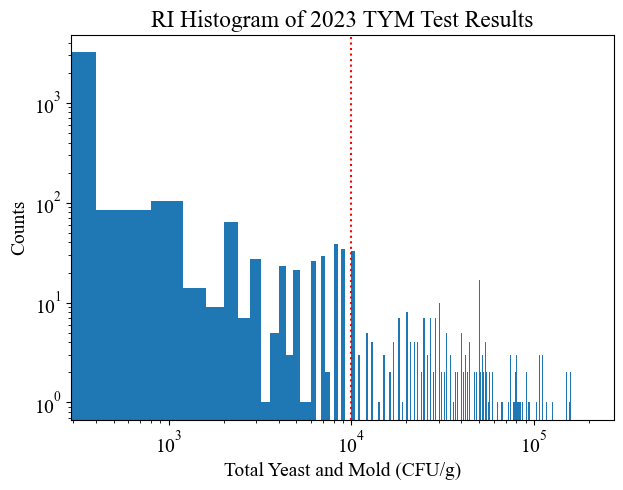

Yeast n Mold Maximum 360000.0 (CFU/g)
Yeast n Mold Minimum 0.0 (CFU/g)


0.08805494235957811

In [87]:
#raw histogram of lab counts
plt.figure(figsize=(7,5))
plt.hist(ri_ym_df['TestResult'],range=[0, 200000],bins=500)
plt.title('RI Histogram of 2023 TYM Test Results')

plt.axvline(10000,ls=':',color='r')
plt.xlabel('Total Yeast and Mold (CFU/g)')
plt.ylabel('Counts')
plt.xscale('log')
plt.yscale('log')
plt.show()

print('Yeast n Mold Maximum', ri_ym_df['TestResult'].max(), '(CFU/g)')
print('Yeast n Mold Minimum', ri_ym_df['TestResult'].min(), '(CFU/g)')
len(ri_ym_df[ri_ym_df['TestResult']>10000])/len(ri_ym_df['TestResult'])

Log-normal distribution parameters :  (np.float64(329.01930535172824), np.float64(-5e-324), np.float64(5.534674899938678e-240))
Gamma distribution parameters :  (np.float64(0.37223220312918603), np.float64(0.617017800567222), np.float64(-7.714114376166793e-27), np.float64(5055.7538249078225))


/Users/grahamanto/Documents/GitHub/cannabis-data-science/cannabis-data-science/.venv/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/Users/grahamanto/Documents/GitHub/cannabis-data-science/cannabis-data-science/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


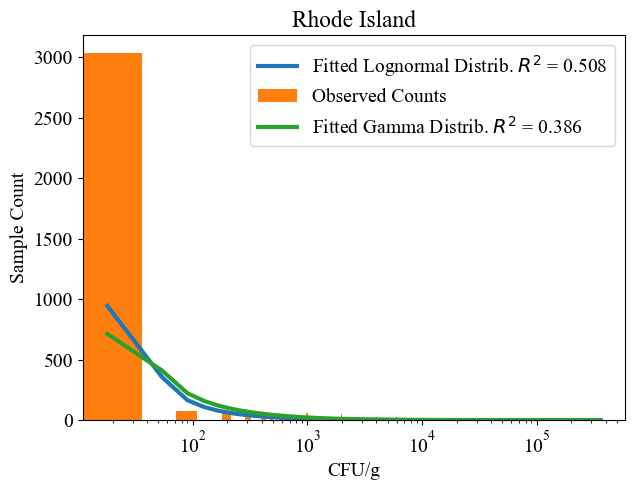

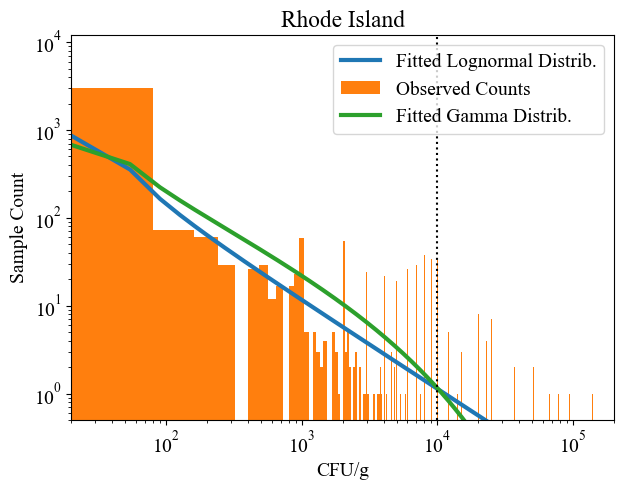

In [88]:
# fitting overdispersion models to state data
mcmc_samples = ri_ym_df['TestResult'] # np.random.poisson(np.random.lognormal(0, 1, 1000))
param= lognorm.fit(mcmc_samples)
gam_param = gengamma.fit(mcmc_samples)

h, bin_edges = np.histogram(mcmc_samples, bins=10000, density=True)
k, _ = np.histogram(mcmc_samples, bins=10000)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
x = np.concat([[1],bin_centers])

#lognorm preds
expected_probs = np.diff(lognorm.cdf(x,*param))
expected_freq = expected_probs * (len(bin_centers))
expp=np.sum(h)/np.sum(expected_probs) * expected_probs
expf = np.sum(k)/np.sum(expected_freq) * expected_freq

#gamma preds
gam_probs = np.diff(gengamma.cdf(x,*gam_param))
gam_freq = gam_probs * (len(bin_centers))
gamp=np.sum(h)/np.sum(gam_probs) * gam_probs
gamf = np.sum(k)/np.sum(gam_freq) * gam_freq

r2_log = sklearn.metrics.r2_score(y_true=h/np.sum(h),y_pred=expp/np.sum(expp))
r2_gam = sklearn.metrics.r2_score(y_true=h,y_pred=gamp)

print("Log-normal distribution parameters : ", param)
print("Gamma distribution parameters : ", gam_param)

f=plt.figure(figsize=(7,5))
plt.plot(x[1:], expf, lw=3, label=["Fitted Lognormal Distrib. $R^2$ = "+ str(np.round(r2_log,3))])
plt.hist(mcmc_samples, bins=10000, label='Observed Counts')#, density=True)
plt.plot(x[1:], gamf, lw=3, label=["Fitted Gamma Distrib. $R^2$ = "+ str(np.round(r2_gam,3))])

plt.xscale('log')
plt.legend(loc='upper right')
plt.title('Rhode Island')
plt.xlabel('CFU/g')
plt.ylabel("Sample Count")
plt.show()
#f.savefig('rhodeisle_loglinear.png',format='png',dpi=600, bbox_inches="tight")

f=plt.figure(figsize=(7,5))
plt.plot(x[1:], expf, lw=3, label=["Fitted Lognormal Distrib."])# $R^2$ = "+ str(np.round(r2_log,3))])
plt.hist(mcmc_samples, range=[0, 200000],bins=2500, label='Observed Counts')#, density=True)
plt.plot(x[1:], gamf, lw=3, label=["Fitted Gamma Distrib."])# $R^2$ = "+ str(np.round(r2_gam,3))])

plt.ylim([.5,12000])
plt.xlim([20,200000])
plt.axvline(10000,ls=':',color='k')

plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')
plt.title('Rhode Island')
plt.xlabel('CFU/g')
plt.ylabel("Sample Count")
plt.show()
#f.savefig('rhodeisle_loglog.png',format='png',dpi=600, bbox_inches="tight")


In [89]:
r2_log = sklearn.metrics.r2_score(y_true=h,y_pred=expp)
r2_gam = sklearn.metrics.r2_score(y_true=h,y_pred=gamp)
print("R Squared statistic Log Normal=", r2_log)
print("R Squared statistic Gamma=", r2_gam)
kl_log = kl_div(h/np.sum(h),expp/np.sum(expp)).sum()
kl_gam = kl_div(h/np.sum(h),gamp/np.sum(gamp)).sum()
print("KL divergence Log Normal=", kl_log)
print("KL divergence Gamma=", kl_gam)

#print(scipy.spatial.distance.jensenshannon(h/np.sum(h),expp/np.sum(expp))**2,scipy.spatial.distance.jensenshannon(h/np.sum(h),gamp/np.sum(gamp))**2)


R Squared statistic Log Normal= 0.5082272235872799
R Squared statistic Gamma= 0.3855881619618984
KL divergence Log Normal= 1.3378357180478955
KL divergence Gamma= 1.741950469265333


In [90]:
len(ccc_ym_df)

#revised set - uncomment if desired
# lab_exclude = ['LabA','LabS']
# ccc_ym_df = ccc_ym_df[~ccc_ym_df['TestingLab(ITL)'].isin(lab_exclude)]
# # ma_ym_df = ma_ym_df[~ma_ym_df['Testing Lab (ITL)'].isin(lab_exclude)]
# len(ccc_ym_df)

48887

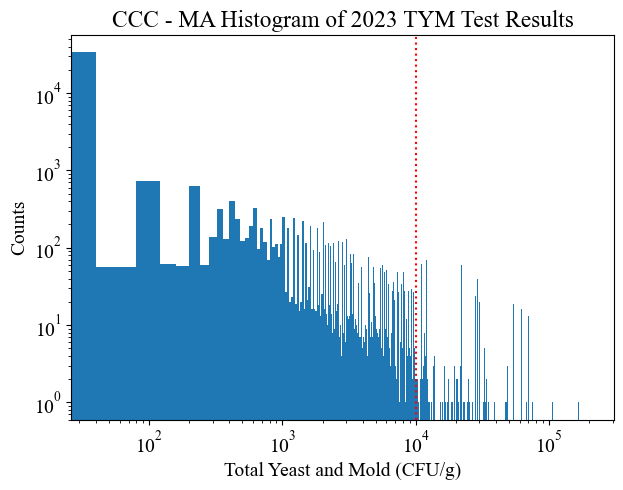

Yeast n Mold Maximum 12000000.0 (CFU/g)
Yeast n Mold Minimum 0.0 (CFU/g)


0.07703479452615215

In [91]:
#raw histogram of lab counts
plt.figure(figsize=(7,5))
plt.hist(ccc_ym_df['TestResult'],range=[0, 200000],bins=5000)
plt.title('CCC - MA Histogram of 2023 TYM Test Results')

plt.axvline(10000,ls=':',color='r')
plt.xlabel('Total Yeast and Mold (CFU/g)')
plt.ylabel('Counts')

plt.xscale('log')
plt.yscale('log')
plt.show()
print('Yeast n Mold Maximum', ccc_ym_df['TestResult'].max(), '(CFU/g)')
print('Yeast n Mold Minimum', ccc_ym_df['TestResult'].min(), '(CFU/g)')
len(ccc_ym_df[ccc_ym_df['TestResult']>10000])/len(ccc_ym_df['TestResult'])

/Users/grahamanto/Documents/GitHub/cannabis-data-science/cannabis-data-science/.venv/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/Users/grahamanto/Documents/GitHub/cannabis-data-science/cannabis-data-science/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Log-normal distribution parameters :  (np.float64(350.8419694023886), np.float64(-5e-324), np.float64(1.2172061565918043e-219))
Gamma distribution parameters :  (np.float64(1.7147252180674957), np.float64(0.22096976249210312), np.float64(-2.4538668862202857e-24), np.float64(5474.702482003176))


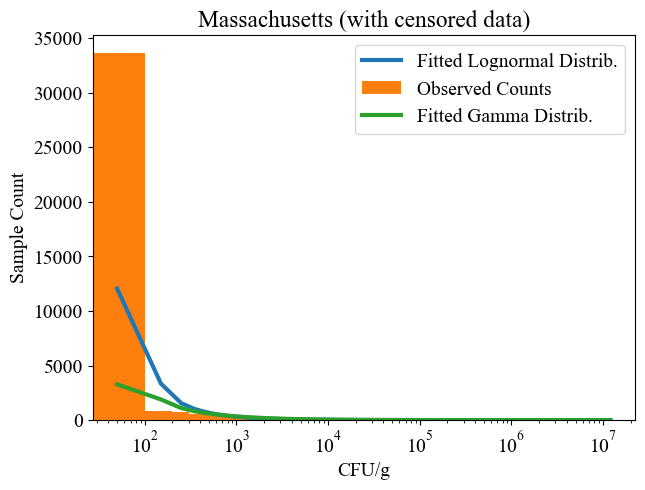

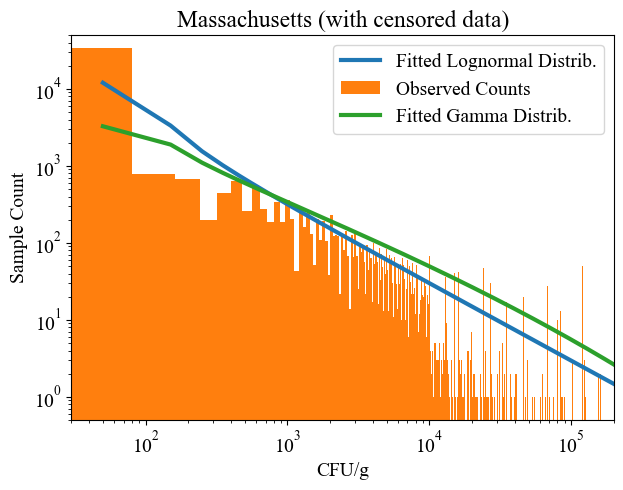

R Squared statistic Log Normal= 0.5829950134264166
R Squared statistic Gamma= 0.1865468739904148
KL divergence Log Normal= 0.7584273753394128
KL divergence Gamma= 1.584644721733926


In [92]:
# fitting overdispersiono models to CCC (Mass) data
mcmc_samples = ccc_ym_df['TestResult'] # np.random.poisson(np.random.lognormal(0, 1, 1000))
param= lognorm.fit(mcmc_samples)
gam_param = gengamma.fit(mcmc_samples)


h, bin_edges = np.histogram(mcmc_samples, bins=120000,density=True)
k, _ = np.histogram(mcmc_samples, bins=120000)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
x = np.concat([[1],bin_centers])

#lognorm preds
expected_probs = np.diff(lognorm.cdf(x,*param))
expected_freq = expected_probs * (len(bin_centers))
expp=np.sum(h)/np.sum(expected_probs) * expected_probs
expf = np.sum(k)/np.sum(expected_freq) * expected_freq

#gamma preds
gam_probs = np.diff(gengamma.cdf(x,*gam_param))
gam_freq = gam_probs * (len(bin_centers))
gamp=np.sum(h)/np.sum(gam_probs) * gam_probs
gamf = np.sum(k)/np.sum(gam_freq) * gam_freq

print("Log-normal distribution parameters : ", param)
print("Gamma distribution parameters : ", gam_param)
f= plt.figure(figsize=(7,5))


plt.plot(x[1:], expf, lw=3, label=["Fitted Lognormal Distrib."]);# $R^2$ = "+ str(np.round(r2_log,3))])
plt.hist(mcmc_samples, bins=120000, label='Observed Counts')#, density=True)
plt.plot(x[1:], gamf, lw=3, label=["Fitted Gamma Distrib."]);# $R^2$ = "+ str(np.round(r2_gam,3))])
plt.xscale('log')
# plt.xlim([39,2e7])
# plt.yscale('log')
plt.legend(loc='upper right')
plt.title('Massachusetts (with censored data)')
plt.xlabel('CFU/g')
plt.ylabel('Sample Count')
plt.show()
#f.savefig('massachusetts_loglinear.png',format='png',dpi=600, bbox_inches="tight")

f=plt.figure(figsize=(7,5))


plt.plot(x[1:], expf, lw=3, label=["Fitted Lognormal Distrib."]);# $R^2$ = "+ str(np.round(r2_log,3))])
plt.hist(mcmc_samples, bins=2500, range=[0,200000], label='Observed Counts')#, density=True)
plt.plot(x[1:], gamf, lw=3, label=["Fitted Gamma Distrib."]);# $R^2$ = "+ str(np.round(r2_gam,3))])
# plt.axvline(10000,ls=':',color='k')

plt.ylim([.5,5e4])
plt.xscale('log')
plt.yscale('log')
plt.xlim([30,2e5])

plt.legend(loc='upper right')
plt.title('Massachusetts (with censored data)')
plt.xlabel('CFU/g')
plt.ylabel('Sample Count')
plt.show()
#f.savefig('massachusetts_loglog.png',format='png',dpi=600, bbox_inches="tight")

r2_log = sklearn.metrics.r2_score(y_true=h/np.sum(h),y_pred=expp/np.sum(expp))
r2_gam = sklearn.metrics.r2_score(y_true=h/np.sum(h),y_pred=gamp/np.sum(gamp))
print("R Squared statistic Log Normal=", r2_log)
print("R Squared statistic Gamma=", r2_gam)

kl_log = kl_div(h/np.sum(h),expp/np.sum(expp)).sum()
kl_gam = kl_div(h/np.sum(h),gamp/np.sum(gamp)).sum()
print("KL divergence Log Normal=", kl_log)
print("KL divergence Gamma=", kl_gam)

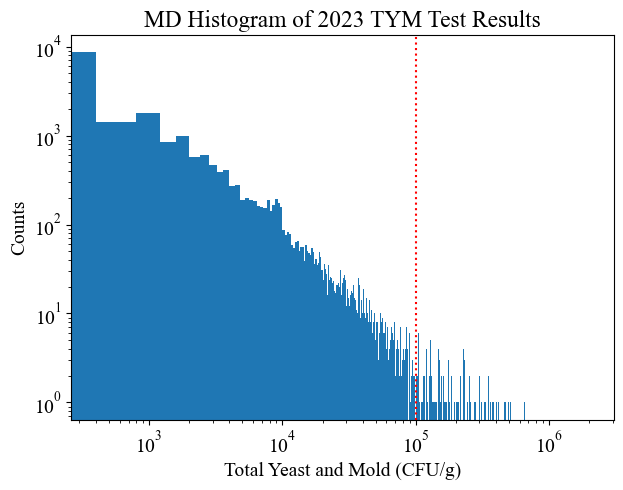

Yeast n Mold Maximum 1990000.0 (CFU/g)
Yeast n Mold Minimum 0.0 (CFU/g)


0.03903930131004367

In [93]:
#raw histogram of lab counts
plt.figure(figsize=(7,5))
plt.hist(md_ym_df['TestResult'],range=[0, 2000000],bins=5000)
plt.title('MD Histogram of 2023 TYM Test Results')

# plt.axvline(10000,ls=':',color='y')
plt.axvline(100000,ls=':',color='r')

plt.xlabel('Total Yeast and Mold (CFU/g)')
plt.ylabel('Counts')
plt.xscale('log')
plt.yscale('log')
plt.show()
print('Yeast n Mold Maximum', md_ym_df['TestResult'].max(), '(CFU/g)')
print('Yeast n Mold Minimum', md_ym_df['TestResult'].min(), '(CFU/g)')
len(md_ym_df[md_ym_df['TestResult']>100000])/len(md_ym_df['TestResult'])


/Users/grahamanto/Documents/GitHub/cannabis-data-science/cannabis-data-science/.venv/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/Users/grahamanto/Documents/GitHub/cannabis-data-science/cannabis-data-science/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Log-normal distribution parameters :  (np.float64(325.74500219050225), np.float64(-5e-324), np.float64(6.01590723809073e-79))
Gamma distribution parameters :  (np.float64(0.9132867976145848), np.float64(0.4379748567680962), np.float64(-1.777302068515016e-23), np.float64(2120.0158926601534))


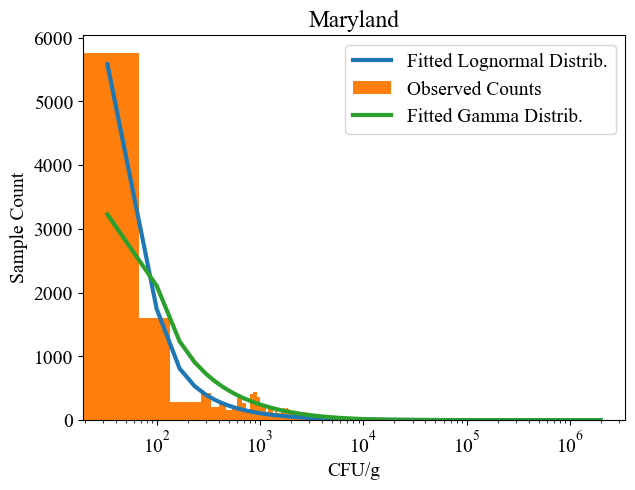

/var/folders/29/xcn1_dxs0xdd35cb3wstn0s00000gn/T/ipykernel_12958/1421306804.py:52: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,4e5])


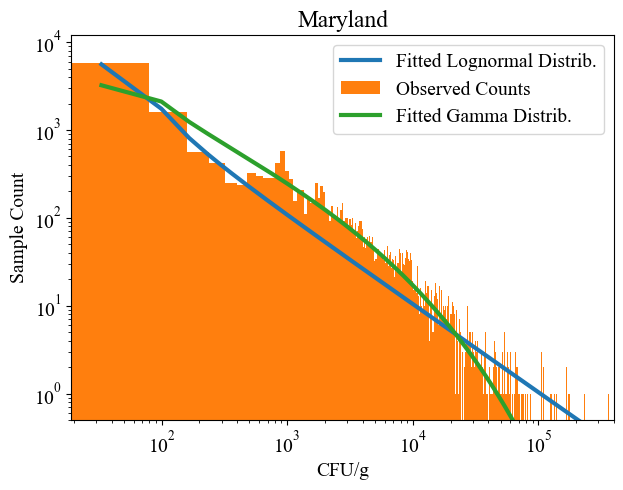

In [94]:
# fitting overdispersion models to state data
mcmc_samples = md_ym_df['TestResult'] # np.random.poisson(np.random.lognormal(0, 1, 1000))
param= lognorm.fit(mcmc_samples)
gam_param = gengamma.fit(mcmc_samples)

h, bin_edges = np.histogram(mcmc_samples, bins=30000, density=True)
k, bin_edge = np.histogram(mcmc_samples, bins=30000)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
x = np.concat([[1],bin_centers])

#lognorm preds
expected_probs = np.diff(lognorm.cdf(x,*param))
expected_freq = expected_probs * (len(bin_centers))
expp=np.sum(h)/np.sum(expected_probs) * expected_probs
expf = np.sum(k)/np.sum(expected_freq) * expected_freq

#gamma preds
gam_probs = np.diff(gengamma.cdf(x,*gam_param))
gam_freq = gam_probs * (len(bin_centers))
gamp=np.sum(h)/np.sum(gam_probs) * gam_probs
gamf = np.sum(k)/np.sum(gam_freq) * gam_freq

r2_log = sklearn.metrics.r2_score(y_true=h,y_pred=expp)
r2_gam = sklearn.metrics.r2_score(y_true=h,y_pred=gamp)

print("Log-normal distribution parameters : ", param)
print("Gamma distribution parameters : ", gam_param)
f = plt.figure(figsize=(7,5))
plt.plot(x[1:], expf, lw=3, label=["Fitted Lognormal Distrib."]);# $R^2$ = "+ str(np.round(r2_log,3))])
plt.hist(mcmc_samples, bins=30000, label='Observed Counts')#, density=True)
plt.plot(x[1:], gamf, lw=3, label=["Fitted Gamma Distrib."]);# $R^2$ = "+ str(np.round(r2_gam,3))])

plt.xscale('log')
# plt.yscale('log')
plt.legend(loc='upper right')
plt.title('Maryland')
plt.xlabel('CFU/g')
plt.ylabel("Sample Count")
plt.show()
#f.savefig('maryland_loglinear.png',format='png',dpi=600, bbox_inches="tight")


f=plt.figure(figsize=(7,5))
plt.plot(x[1:], expf, lw=3, label=["Fitted Lognormal Distrib."]);# $R^2$ = "+ str(np.round(r2_log,3))])
plt.hist(mcmc_samples, bins=5000, range=[0,4e5], label='Observed Counts')#, density=True)
plt.plot(x[1:], gamf, lw=3, label=["Fitted Gamma Distrib."]);# $R^2$ = "+ str(np.round(r2_gam,3))])
# plt.axvline(100000,ls=':',color='k')

plt.xscale('log')
plt.yscale('log')
plt.ylim(.5,12000)
plt.xlim([0,4e5])

plt.legend(loc='upper right')
plt.title('Maryland')
plt.xlabel('CFU/g')
plt.ylabel("Sample Count")
plt.show()
#f.savefig('maryland_loglog.png',format='png',dpi=600, bbox_inches="tight")


In [95]:

r2_log = sklearn.metrics.r2_score(y_true=h,y_pred=expp)
r2_gam = sklearn.metrics.r2_score(y_true=h,y_pred=gamp)
print("R Squared statistic Log Normal=", r2_log)
print("R Squared statistic Gamma=", r2_gam)


kl_log = kl_div(h/np.sum(h),expp/np.sum(expp)).sum()
kl_gam = kl_div(h/np.sum(h),gamp/np.sum(gamp)).sum()
print("KL divergence Log Normal=", kl_log)
print("KL divergence Gamma=", kl_gam)

#scipy.spatial.distance.jensenshannon(h/np.sum(h),expp/np.sum(expp))**2,scipy.spatial.distance.jensenshannon(h/np.sum(h),gamp/np.sum(gamp))**2

R Squared statistic Log Normal= 0.9753967026101843
R Squared statistic Gamma= 0.7736030258859752
KL divergence Log Normal= 0.381511532542842
KL divergence Gamma= 0.3451272290916202


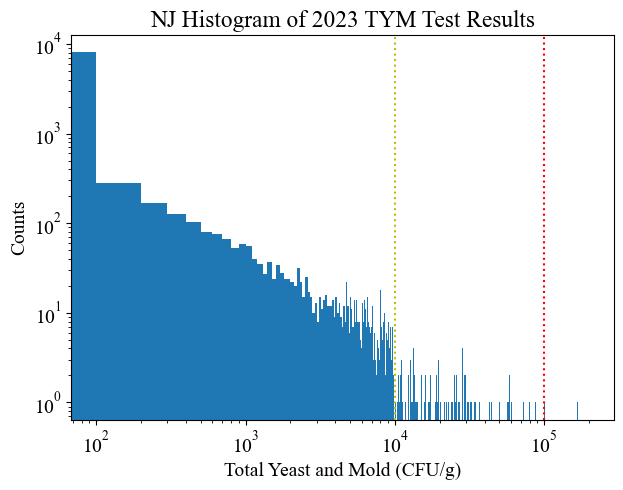

Yeast n Mold Maximum 2365282.98 (CFU/g)
Yeast n Mold Minimum 0.0 (CFU/g)


0.037338893100833964

In [96]:
#raw histogram of lab counts
plt.figure(figsize=(7,5))
plt.hist(nj_ym_df['TestResult'],range=[0, 200000],bins=2000)
plt.title('NJ Histogram of 2023 TYM Test Results')

plt.axvline(10000,ls=':',color='y')
plt.axvline(100000,ls=':',color='r')

plt.xlabel('Total Yeast and Mold (CFU/g)')
plt.ylabel('Counts')
plt.xscale('log')
plt.yscale('log')
plt.show()
print('Yeast n Mold Maximum', nj_ym_df['TestResult'].max(), '(CFU/g)')
print('Yeast n Mold Minimum', nj_ym_df['TestResult'].min(), '(CFU/g)')

len(nj_ym_df[nj_ym_df['TestResult']>10000])/len(nj_ym_df['TestResult'])


/Users/grahamanto/Documents/GitHub/cannabis-data-science/cannabis-data-science/.venv/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/Users/grahamanto/Documents/GitHub/cannabis-data-science/cannabis-data-science/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Log-normal distribution parameters :  (np.float64(364.4252650710315), np.float64(-5e-324), np.float64(4.865541330692154e-127))
Gamma distribution parameters :  (np.float64(3.0543090143818765), np.float64(0.22476066268457368), np.float64(-1.3206282974200647e-20), np.float64(3.4846492830356186))


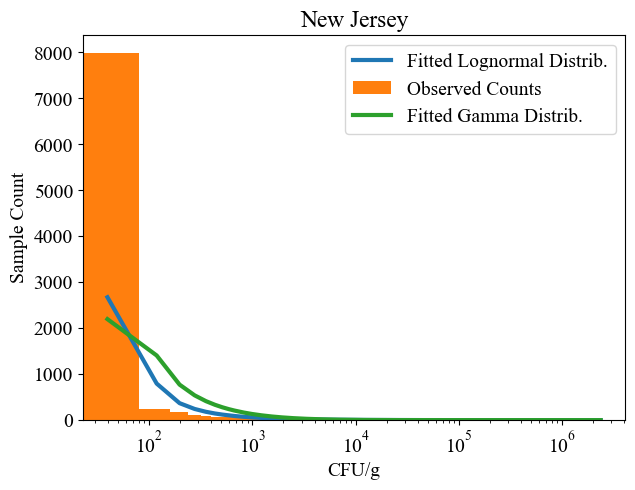

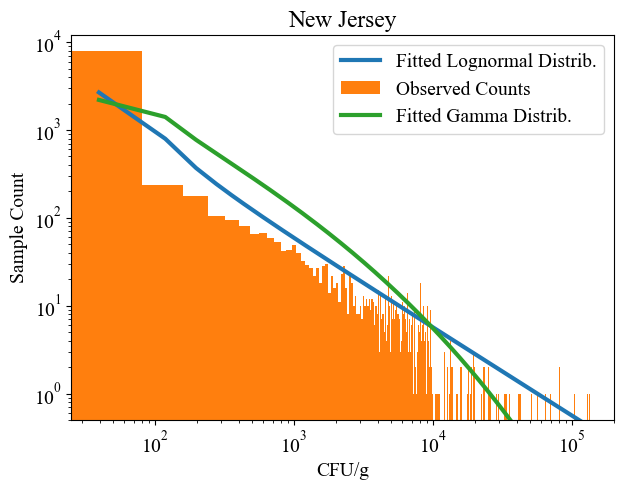

In [97]:
# fitting overdispersion models to state NJ data
mcmc_samples = nj_ym_df['TestResult'] # np.random.poisson(np.random.lognormal(0, 1, 1000))
param= lognorm.fit(mcmc_samples)
gam_param = gengamma.fit(mcmc_samples)


h, bin_edges = np.histogram(mcmc_samples, bins=30000, density=True)
k, _ = np.histogram(mcmc_samples, bins=30000)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
x = np.concat([[1],bin_centers])

#lognorm preds
expected_probs = np.diff(lognorm.cdf(x,*param))
expected_freq = expected_probs * (len(bin_centers))
expp=np.sum(h)/np.sum(expected_probs) * expected_probs
expf = np.sum(k)/np.sum(expected_freq) * expected_freq

#gamma preds
gam_probs = np.diff(gengamma.cdf(x,*gam_param))
gam_freq = gam_probs * (len(bin_centers))
gamp=np.sum(h)/np.sum(gam_probs) * gam_probs
gamf = np.sum(k)/np.sum(gam_freq) * gam_freq


r2_log = sklearn.metrics.r2_score(y_true=h,y_pred=expp)
r2_gam = sklearn.metrics.r2_score(y_true=h,y_pred=gamp)

print("Log-normal distribution parameters : ", param)
print("Gamma distribution parameters : ", gam_param)
f = plt.figure(figsize=(7,5))
plt.plot(x[1:], expf, lw=3, label=["Fitted Lognormal Distrib."]);# $R^2$ = "+ str(np.round(r2_log,3))])
plt.hist(mcmc_samples, bins=30000, label='Observed Counts')#, density=True)
plt.plot(x[1:], gamf, lw=3, label=["Fitted Gamma Distrib."]);# $R^2$ = "+ str(np.round(r2_gam,3))])

plt.xscale('log')
# plt.yscale('log')
plt.legend(loc='upper right')
plt.title('New Jersey')
plt.xlabel('CFU/g')
plt.ylabel("Sample Count")
plt.show()
#f.savefig('newjersey_loglinear.png',format='png',dpi=600, bbox_inches="tight")
f = plt.figure(figsize=(7,5))
plt.plot(x[1:], expf, lw=3, label=["Fitted Lognormal Distrib."])# $R^2$ = "+ str(np.round(r2_log,3))])
plt.hist(mcmc_samples, bins=2500, range=[0,200000], label='Observed Counts')#, density=True)
plt.plot(x[1:], gamf, lw=3, label=["Fitted Gamma Distrib."])# $R^2$ = "+ str(np.round(r2_gam,3))])
# plt.axvline(10000,ls=':',color='k')

plt.xscale('log')
plt.xlim([25,2e5])

plt.yscale('log')
plt.ylim([.5,12000])

plt.legend(loc='upper right')
plt.title('New Jersey')
plt.xlabel('CFU/g')
plt.ylabel("Sample Count")
plt.show()
#f.savefig('newjersey_loglog.png',format='png',dpi=600, bbox_inches="tight")


In [98]:
r2_log = sklearn.metrics.r2_score(y_true=h,y_pred=expp)
r2_gam = sklearn.metrics.r2_score(y_true=h,y_pred=gamp)
print("R Squared statistic Log Normal=", r2_log)
print("R Squared statistic Gamma=", r2_gam)

kl_log = kl_div(h/np.sum(h),expp/np.sum(expp)).sum()
kl_gam = kl_div(h/np.sum(h),gamp/np.sum(gamp)).sum()
print("KL divergence Log Normal=", kl_log)
print("KL divergence Gamma=", kl_gam)

#scipy.spatial.distance.jensenshannon(h/np.sum(h),expp/np.sum(expp))**2,scipy.spatial.distance.jensenshannon(h/np.sum(h),gamp/np.sum(gamp))**2

R Squared statistic Log Normal= 0.5529824654676159
R Squared statistic Gamma= 0.4405574528986803
KL divergence Log Normal= 0.7240420849370439
KL divergence Gamma= 0.8158015773664501


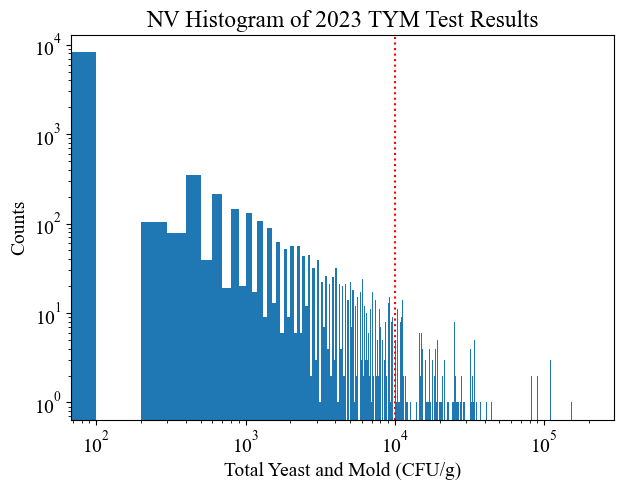

Yeast n Mold Maximum 1000001.0 (CFU/g)
Yeast n Mold Minimum 0.0 (CFU/g)


0.08291106063253538

In [99]:
#raw histogram of lab counts
plt.figure(figsize=(7,5))
plt.hist(nv_ym_df['TestResult'],range=[0, 200000],bins=2000)
plt.title('NV Histogram of 2023 TYM Test Results')

plt.axvline(10000,ls=':',color='r')
# plt.xlim([0,2000000])
plt.xlabel('Total Yeast and Mold (CFU/g)')
plt.ylabel('Counts')
plt.xscale('log')
plt.yscale('log')

plt.show()
print('Yeast n Mold Maximum', nv_ym_df['TestResult'].max(), '(CFU/g)')
print('Yeast n Mold Minimum', nv_ym_df['TestResult'].min(), '(CFU/g)')

len(nv_ym_df[nv_ym_df['TestResult']>10000])/len(nv_ym_df['TestResult'])

/Users/grahamanto/Documents/GitHub/cannabis-data-science/cannabis-data-science/.venv/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:6626: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/Users/grahamanto/Documents/GitHub/cannabis-data-science/cannabis-data-science/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Log-normal distribution parameters :  (np.float64(339.87823818088776), np.float64(-5e-324), np.float64(9.610860263613022e-231))
Gamma distribution parameters :  (np.float64(1.1552270736210644), np.float64(0.31368888127685823), np.float64(-1.4598917566608073e-26), np.float64(3306.4596990827154))


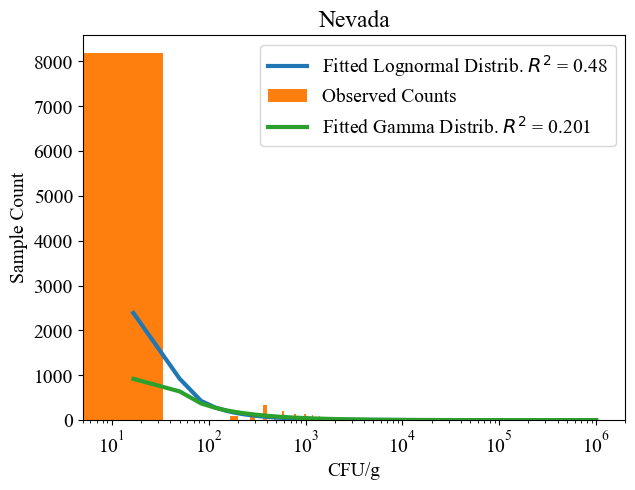

/var/folders/29/xcn1_dxs0xdd35cb3wstn0s00000gn/T/ipykernel_12958/2859414813.py:59: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,2e5])


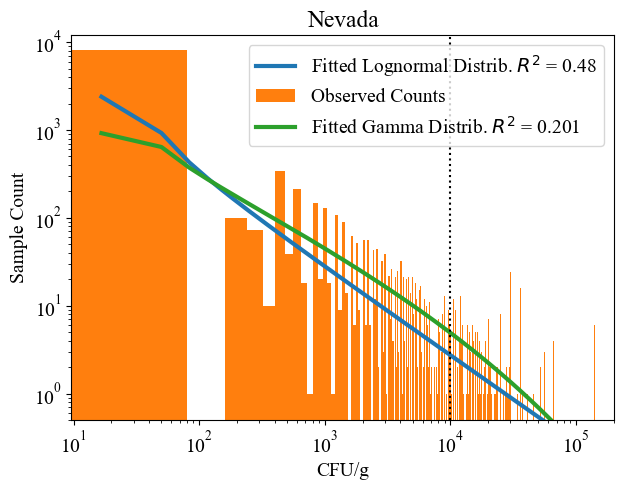

In [100]:
# fitting overdispersion models to NV data
mcmc_samples = nv_ym_df['TestResult'] # np.random.poisson(np.random.lognormal(0, 1, 1000))
param= lognorm.fit(mcmc_samples)
gam_param = gengamma.fit(mcmc_samples)


h, bin_edges = np.histogram(mcmc_samples, bins=30000, density=True)
k, _ = np.histogram(mcmc_samples, bins=30000)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
x = np.concat([[1],bin_centers])

#lognorm preds
expected_probs = np.diff(lognorm.cdf(x,*param))
expected_freq = expected_probs * (len(bin_centers))
expp=np.sum(h)/np.sum(expected_probs) * expected_probs
expf = np.sum(k)/np.sum(expected_freq) * expected_freq

#gamma preds
gam_probs = np.diff(gengamma.cdf(x,*gam_param))
gam_freq = gam_probs * (len(bin_centers))
gamp=np.sum(h)/np.sum(gam_probs) * gam_probs
gamf = np.sum(k)/np.sum(gam_freq) * gam_freq

r2_log = sklearn.metrics.r2_score(y_true=h,y_pred=expp)
r2_gam = sklearn.metrics.r2_score(y_true=h,y_pred=gamp)

print("Log-normal distribution parameters : ", param)
print("Gamma distribution parameters : ", gam_param)
f=plt.figure(figsize=(7,5))

plt.plot(x[1:], expf, lw=3, label=["Fitted Lognormal Distrib. $R^2$ = "+ str(np.round(r2_log,3))])
plt.hist(mcmc_samples, bins=30000, label='Observed Counts')#, density=True)
plt.plot(x[1:], gamf, lw=3, label=["Fitted Gamma Distrib. $R^2$ = "+ str(np.round(r2_gam,3))])
plt.xscale('log')
# plt.yscale('log')
plt.legend(loc='upper right')
plt.title('Nevada')
plt.xlabel('CFU/g')
plt.ylabel("Sample Count")
plt.xlim([5,20e5])
plt.show()
#f.savefig('nevada_loglinear.png',format='png',dpi=600, bbox_inches="tight")

f=plt.figure(figsize=(7,5))

plt.plot(x[1:], expf, lw=3, label=["Fitted Lognormal Distrib. $R^2$ = "+ str(np.round(r2_log,3))])
plt.hist(mcmc_samples, bins=2500, range=[0,200000], label='Observed Counts')#, density=True)
plt.plot(x[1:], gamf, lw=3, label=["Fitted Gamma Distrib. $R^2$ = "+ str(np.round(r2_gam,3))])
plt.axvline(10000,ls=':',color='k')

plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')
# plt.axvline(10000,ls=':',color='r')

plt.title('Nevada')
plt.xlabel('CFU/g')
plt.ylabel("Sample Count")
plt.xlim([0,2e5])
plt.ylim([.5,1.2e4])
plt.show()
#f.savefig('nevada_loglog.png',format='png',dpi=600, bbox_inches="tight")


In [101]:
r2_log = sklearn.metrics.r2_score(y_true=h,y_pred=expp)
r2_gam = sklearn.metrics.r2_score(y_true=h,y_pred=gamp)
print("R Squared statistic Log Normal=", r2_log)
print("R Squared tatistic Gamma=", r2_gam)
kl_log = kl_div(h/np.sum(h),expp/np.sum(expp)).sum()
kl_gam = kl_div(h/np.sum(h),gamp/np.sum(gamp)).sum()
print("KL divergence Log Normal=", kl_log)
print("KL divergence Gamma=", kl_gam)

#print(scipy.spatial.distance.jensenshannon(h/np.sum(h),expp/np.sum(expp))**2,scipy.spatial.distance.jensenshannon(h/np.sum(h),gamp/np.sum(gamp))**2)

R Squared statistic Log Normal= 0.48004706667524866
R Squared tatistic Gamma= 0.2009319677247241
KL divergence Log Normal= 1.2881808547166498
KL divergence Gamma= 1.85697615316124
